In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import statistics

# подключимся к диску
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# создадим сетки с долготами и широтами

# координаты по оси X
long_left = -119.5
long_right = -117.5

# координаты по оси Y
lat_top = 39.007
lat_bottom = 37.952

# шаг Δx
delta_long = 0.1

# шаг Δy
delta_lat = -0.07535714285714283

# общее число шагов по сетке
long_steps_total = 21
lat_steps_total = 15

# создадим массив со всеми долготами
longitudes = np.arange(long_left, long_right + delta_long, delta_long)
longitudes = np.repeat([longitudes], lat_steps_total, axis=0)
longitudes = np.round(longitudes, 6)

# создадим массив со всеми широтами
latitudes = np.arange(lat_top, lat_bottom, delta_lat)
# # отсоритуем сверху вниз
latitudes = latitudes[np.argsort(-latitudes)]
latitudes = np.repeat(latitudes.reshape(lat_steps_total, 1), long_steps_total, axis=1)
latitudes = np.round(latitudes, 6)


# создадим массив точек во времени, когда проводился расчет признаков (раз в 30 дней)
first_data = np.datetime64('2009-08-07')
last_data = np.datetime64('2023-01-26')
time_step = 30
time_steps_total = 165

date_points = np.arange(first_data, last_data + time_step, time_step)

In [ ]:
# создадим датафрейм, куда будем сохранять признаки
data = pd.DataFrame(columns=['Year', 'Month', 'Day', 'Longitude', 'Latitude', 'F4', 'F5', 'F6', 'S9', 'S11'])


path = '/content/drive/MyDrive/диплом/data_subset'
for i in range(0, time_steps_total):

    # создадим массивы отдельно с годом, месяцем и днем проведения соответствующих расчетов признаков
    year = np.repeat(date_points[i].astype(object).year, long_steps_total * lat_steps_total).reshape(lat_steps_total, long_steps_total)
    month = np.repeat(date_points[i].astype(object).month, long_steps_total * lat_steps_total).reshape(lat_steps_total, long_steps_total)
    day = np.repeat(date_points[i].astype(object).day, long_steps_total * lat_steps_total).reshape(lat_steps_total, long_steps_total)

    # скачаем поля признаков, рассчитанные для соответствующей даты
    f4 = pd.read_csv(f'{path}/GPS features/Student of divergence with T 360 and 360/F4_{i}.flt', sep="\s+", header=None, skiprows=1)
    f5 = pd.read_csv(f'{path}/GPS features/Student of rotor with T 360 and 360/F5_{i}.flt', sep="\s+", header=None, skiprows=1)
    f6 = pd.read_csv(f'{path}/GPS features/Student of shear with T 360 and 360/F6_{i}.flt', sep="\s+", header=None, skiprows=1)
    s1 = pd.read_csv(f'{path}/Seismological features/Density of epicenters/S1_{i+81}.flt', sep="\s+", header=None, skiprows=1)
    s8 = pd.read_csv(f'{path}/Seismological features/Quantile of density of epicenters/S8_{i+81}.flt', sep="\s+", header=None, skiprows=1)
    s11 = pd.read_csv(f'{path}/Seismological features/Student of mean magnitude/S11_{i}.flt', sep="\s+", header=None, skiprows=1)

    s9 = s1 / (s8 + 0.001)

    # объединим год, месяц, день, долготу, широту и соответствующие им значения признаков в куб
    features = np.dstack((year, month, day, longitudes, latitudes, f4, f5, f6, s9, s11))
    # сделаем из куба двумерный массив, где каждая строчка состоит из года, месяца, дня, долготы, широты и соответствующих им значений признаков
    features_2d = np.reshape(features, (-1, features.shape[-1]))

    # добавим массив в общий датафрейм
    data = data.append(pd.DataFrame(features_2d, columns=data.columns), ignore_index=True)


data.head()

In [ ]:
data.shape # число строк = 21 * 15 * 165 = 51 975

(51975, 10)

In [ ]:
# удалим строки, в которых значения хотя бы одной из колонок F4, F5, F6 равны NaN
data.dropna(subset=['F4', 'F5', 'F6'], how='any', inplace=True)
data.reset_index(drop=True, inplace=True)

data = data.astype({'Year': 'int64', 'Month': 'int64', 'Day': 'int64'})

data.shape # 40 413 строк

(40413, 10)

In [ ]:
data.to_excel("data_subset.xlsx")

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/диплом/data_subset.xlsx')

# Расчет целевой переменной

In [ ]:
# загрузим каталог землетрясений М5.0+, произошедших в рассматриваемой области
catalog = pd.read_csv("/content/drive/MyDrive/диплом/M5.0+ earthquakes in CA.txt", sep="\s+")
catalog.rename(columns={"Class": "Magnitude"}, inplace=True)

# удалим землетрясения, произошедшие раньше 07.08.2009, т.к. первые признаки по GPS данным посчитаны для периода 08.07.2009-07.08.2009 (30 дней)
indexes = catalog[(catalog['YYYY'] < 2009) | ((catalog['YYYY'] == 2009) & (catalog['MM'] <= 8) & (catalog['DD'] <= 7))].index
catalog.drop(indexes, inplace=True)
catalog.reset_index(drop=True, inplace=True)
catalog.drop(['HH', 'mm', 'ssss'], axis=1, inplace=True)

catalog.head()

,YYYY,MM,DD,LAT,LONG,Depth,Magnitude
0,2009,9,20,32.370667,-115.261167,9.987,5.08
1,2009,10,1,36.387833,-117.858667,3.985,5.00
2,2009,10,3,36.391000,-117.860833,-1.770,5.19
3,2009,12,30,32.464000,-115.189167,5.971,5.80
4,2010,1,10,40.652000,-124.692500,28.737,6.50


In [ ]:
# часть землетрясений в датафрейме - это афтершоки, последовавшие за главным толчком в каком-то месяце, и именно главный удар нам нужно предсказать
# т.к. для каждого участка в каждом месяце мы должны предсказать магнитуду одного (главного) землетрясения, нужно удалить из датасета все толчки,
# произошедшие в один месяц, кроме самого сильного, если их долгота и широта отличаются не больше, чем на (delta_long + 0.005) и (delta_lat + 0.00375)

print(catalog.shape)

i = 0
n = catalog.shape[0] - 1
while i != n:
  if ((catalog.iloc[i, 0] == catalog.iloc[i+1, 0]) &                                        # YYYY
      (catalog.iloc[i, 1] == catalog.iloc[i+1, 1]) &                                        # MM
      (np.absolute(catalog.iloc[i, 3] - catalog.iloc[i+1, 3]) <= (-delta_lat + 0.00375)) &  # LAT
      (np.absolute(catalog.iloc[i, 4] - catalog.iloc[i+1, 4]) <= (delta_long + 0.005))):    # LONG
     if (catalog.iloc[i, 6] <= catalog.iloc[i+1, 6]):
        catalog.drop(index=i, axis=0, inplace=True)
        catalog.reset_index(drop=True, inplace=True)
     else:
        catalog.drop(index=i+1, axis=0, inplace=True)
        catalog.reset_index(drop=True, inplace=True)
     n -= 1
  else:
    i += 1

catalog.shape

(69, 7)


(56, 7)

In [ ]:
# добавим колонку с классом (1, если было землетрясение магнитуды 5.0+, иначе 0)
catalog['Class'] = 1

# выберем те землетрясения, которые произошли в рассматриваемой области
targets = catalog[(catalog['LAT'] >= lat_bottom) & (catalog['LAT'] <= lat_top) & (catalog['LONG'] >= long_left) & (catalog['LONG'] <= long_right)]

In [ ]:
targets.to_excel("targets.xlsx")

In [ ]:
targets = pd.read_excel('/content/drive/MyDrive/диплом/targets.xlsx')

# Объединение признаков и таргета в общий датасет

In [ ]:
# создадим колонки с датами
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
targets['YYYY-MM-DD'] = pd.to_datetime(targets[['YYYY', 'MM', 'DD']].astype('str').T.agg('-'.join))
data['First-day-of-forecast'] = data['Date'] + pd.Timedelta(1, unit='D')
data['Last-day-of-forecast'] = data['Date'] + pd.Timedelta(31, unit='D')

In [ ]:
# объединим датасеты с помощью sql
conn = sqlite3.connect(':memory:')

data.to_sql('data', conn, index=False)
targets.to_sql('targets', conn, index=False)

qry = '''
    select
        *
    from
        data left join targets on
        (targets.'YYYY-MM-DD' between data.'First-day-of-forecast' and data.'Last-day-of-forecast' and
        targets.LONG between data.Longitude and data.Longitude + 0.1 and
        targets.LAT between data.Latitude and data.Latitude + 0.07535714285714283)
    '''
dataset = pd.read_sql_query(qry, conn)

In [ ]:
dataset.fillna({'Magnitude': 0, 'Danger level': 0, 'Class': 0}, inplace=True)
dataset = dataset.astype({'Danger level': 'int64', 'Class': 'int64'})
dataset.drop(['Date', 'First-day-of-forecast', 'Last-day-of-forecast', 'YYYY', 'MM', 'DD', 'LAT', 'LONG', 'Depth', 'YYYY-MM-DD'], axis=1,
             inplace=True)

In [ ]:
dataset['Class'].value_counts()

0    40405
1        8
Name: Class, dtype: int64

In [ ]:
dataset.groupby(['Class'])[['F4', 'F5', 'F6']].mean()

,F4,F5,F6
Class,,,
0,-0.564271,0.168103,0.652734
1,-2.827620,1.376178,3.861411


In [ ]:
dataset.groupby(['Class'])[['F4', 'F5', 'F6']].median()

,F4,F5,F6
Class,,,
0,-0.361157,-0.011640,0.308147
1,-1.834378,-1.833199,2.262221


In [ ]:
dataset.to_excel("dataset.xlsx")

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/диплом/dataset.xlsx')

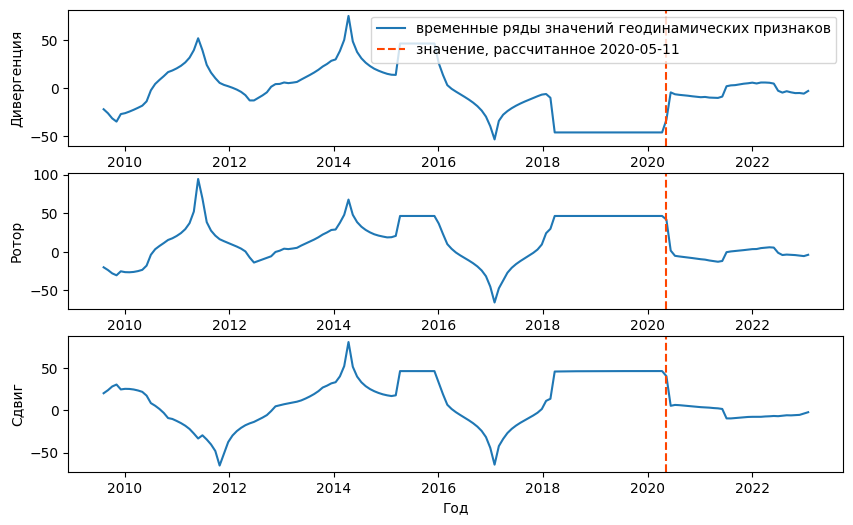

In [ ]:
mag_ = 6.5

# нарисуем график для временного ряда значений F4, F5, F6
long_ = dataset[dataset['Magnitude'] == mag_]['Longitude'].item()
lat_ = dataset[dataset['Magnitude'] == mag_]['Latitude'].item()

date = pd.to_datetime(dataset[dataset['Magnitude'] == mag_][['Year', 'Month', 'Day']].astype(str)).item()

f4_ts = dataset[(dataset['Longitude'] == long_) & (dataset['Latitude'] == lat_)]['F4']
f5_ts = dataset[(dataset['Longitude'] == long_) & (dataset['Latitude'] == lat_)]['F5']
f6_ts = dataset[(dataset['Longitude'] == long_) & (dataset['Latitude'] == lat_)]['F6']

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(date_points, f4_ts, label='временные ряды значений геодинамических признаков')
plt.axvline(date, color='orangered', linestyle='--', label=f'значение, рассчитанное {date.date()}')
plt.ylabel('Дивергенция')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(date_points, f5_ts)
plt.axvline(date, color='orangered', linestyle='--')
plt.ylabel('Ротор')

plt.subplot(3, 1, 3)
plt.plot(date_points, f6_ts)
plt.axvline(date, color='orangered', linestyle='--')
plt.xlabel('Год')
plt.ylabel('Сдвиг')

plt.show()

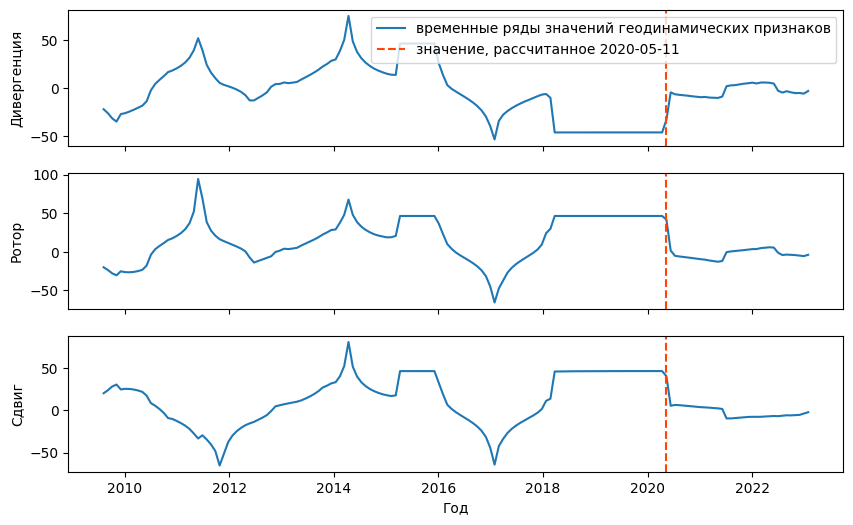

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex = True)
ax[0].plot(date_points, f4_ts, label='временные ряды значений геодинамических признаков')
ax[0].axvline(date, color='orangered', linestyle='--', label=f'значение, рассчитанное {date.date()}')
ax[0].set_ylabel('Дивергенция')
ax[0].legend()
ax[1].plot(date_points, f5_ts)
ax[1].axvline(date, color='orangered', linestyle='--')
ax[1].set_ylabel('Ротор')
ax[2].plot(date_points, f6_ts)
ax[2].axvline(date, color='orangered', linestyle='--')
ax[2].set_xlabel('Год')
ax[2].set_ylabel('Сдвиг')

plt.show()

# Построение модели

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/диплом/dataset.xlsx')

In [ ]:
data_for_train = dataset[['F4', 'F5', 'F6', 'S9', 'S11', 'Class']]

# нормализуем данные
scaler = MinMaxScaler()
scaler = scaler.fit(data_for_train[['F4', 'F5', 'F6', 'S9', 'S11']])
data_for_train_scaled = scaler.transform(data_for_train[['F4', 'F5', 'F6', 'S9', 'S11']])
dataset = pd.concat([pd.DataFrame(data_for_train_scaled, columns=['F4', 'F5', 'F6', 'S9', 'S11']), data_for_train['Class']], axis=1)

In [ ]:
# наблюдается сильный дисбаланс классов (всего 8 землетрясений за все время <=> только 8 объектов класса 1)
# из-за этого не можем обучать модель на всем наборе данных
# обучим 100 деревьев решений, каждое - на рандомной подвыборке класса 0 и фиксированных 70% объектов класса 1
zeros = dataset[dataset['Class'] == 0].index
ones = dataset[dataset['Class'] == 1].index

ones_train = ones[:int(0.7 * ones.shape[0])]
ones_test = ones[int(0.7 * ones.shape[0]):]

n_estimators = 100
zeros_num_for_train = int(0.7 * ones.shape[0])
zeros_num_for_test = ones.shape[0] - int(0.7 * ones.shape[0])

In [ ]:
geodynamic_features = ['F4', 'F5', 'F6']
seismological_features = ['S9', 'S11']
both_types_of_features = ['F4', 'F5', 'F6', 'S9', 'S11']


def rf_train(type_of_features):
  clf_s = list()
  feature_importances = list()

  for i in range(0, n_estimators):
    # создадим датасет для обучения дерева
    idxs = np.random.choice(zeros, size=zeros_num_for_train, replace=False)
    zeros_subset_for_train = dataset.iloc[idxs]
    dataset_for_train = pd.concat([zeros_subset_for_train, dataset.iloc[ones_train]])
    X = dataset_for_train[type_of_features]
    y = dataset_for_train['Class']
    X, y = shuffle(X, y, random_state=0)

    # обучим дерево
    clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)
    clf = clf.fit(X, y)

    clf_s.append(clf)
    feature_importances.append(np.argmax(clf.feature_importances_))

  return clf_s, feature_importances

In [ ]:
def rf_test(type_of_features, clf_s, feature_importances):
  idxs = np.random.choice(zeros, size=zeros_num_for_test, replace=False)
  zeros_subset_for_test = dataset.iloc[idxs]
  dataset_for_test = pd.concat([zeros_subset_for_test, dataset.iloc[ones_test]])
  X_test = dataset_for_test[type_of_features]
  y_test = dataset_for_test['Class']

  pod_values = list()
  far_values = list()

  for i in range(0, n_estimators):
    y_pred = clf_s[i].predict(X_test)

    CM = confusion_matrix(y_test, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    clf_pod = TP/(TP + FN)
    clf_far = FP/(TN + FP)

    pod_values.append(clf_pod)
    far_values.append(clf_far)


  pod_final = np.mean(pod_values)
  far_final = np.mean(far_values)

  scores = f'Средние значения метрик: \nPOD: {np.round(pod_final, 3)} \nFAR: {np.round(far_final, 3)} \nR: {np.round(pod_final - far_final, 3)}'
  return print(scores)

In [ ]:
# вариант 1: используем для обучения модели только геодинамические признаки
clf_s, feature_importances = rf_train(geodynamic_features)
rf_test(geodynamic_features, clf_s, feature_importances)

# найдем самый значимый признак
mode = statistics.mode(feature_importances)
print(f'\nНаиболее важный признак: {geodynamic_features[mode]}')

Средние значения метрик: 
POD: 0.457 
FAR: 0.415 
R: 0.042

Наиболее важный признак: F4


In [ ]:
# вариант 2: используем для обучения модели только сейсмологические признаки
clf_s, feature_importances = rf_train(seismological_features)
rf_test(seismological_features, clf_s, feature_importances)

# найдем самый значимый признак
mode = statistics.mode(feature_importances)
print(f'\nНаиболее важный признак: {seismological_features[mode]}')

Средние значения метрик: 
POD: 0.503 
FAR: 0.26 
R: 0.243

Наиболее важный признак: S11


In [ ]:
# вариант 3: используем для обучения модели одновременно два типа признаков
clf_s, feature_importances = rf_train(both_types_of_features)
rf_test(both_types_of_features, clf_s, feature_importances)

# найдем самый значимый признак
mode = statistics.mode(feature_importances)
print(f'\nНаиболее важный признак: {both_types_of_features[mode]}')

Средние значения метрик: 
POD: 0.447 
FAR: 0.345 
R: 0.102

Наиболее важный признак: S11


In [ ]:
# попробуем искусственно увеличить число объектов класса 1
f4_real = dataset[dataset['Class'] == 1]['F4']
f5_real = dataset[dataset['Class'] == 1]['F5']
f6_real = dataset[dataset['Class'] == 1]['F6']
s9_real = dataset[dataset['Class'] == 1]['S9']
s11_real = dataset[dataset['Class'] == 1]['S11']
class_ = 1

for i in range(0, 20):
  f4 = np.random.choice(f4_real, size=1, replace=False).item()
  f5 = np.random.choice(f5_real, size=1, replace=False).item()
  f6 = np.random.choice(f6_real, size=1, replace=False).item()
  s9 = np.random.choice(s9_real, size=1, replace=False).item()
  s11 = np.random.choice(s11_real, size=1, replace=False).item()

  dataset = dataset.append(pd.DataFrame(np.array([f4, f5, f5, s9, s11, class_]).reshape(1, -1), columns=dataset.columns), ignore_index=True)

In [ ]:
# обучим 100 деревьев решений, каждое - на рандомной подвыборке класса 0 и фиксированных 70% объектов класса 1
zeros = dataset[dataset['Class'] == 0].index
ones = dataset[dataset['Class'] == 1].index

ones_train = ones[:int(0.7 * ones.shape[0])]
ones_test = ones[int(0.7 * ones.shape[0]):]

n_estimators = 100
zeros_num_for_train = int(0.7 * ones.shape[0])
zeros_num_for_test = int(0.3 * ones.shape[0])

In [ ]:
# вариант 1: используем для обучения модели только геодинамические признаки
clf_s, feature_importances = rf_train(geodynamic_features)
rf_test(geodynamic_features, clf_s, feature_importances)

# найдем самый значимый признак
mode = statistics.mode(feature_importances)
print(f'\nНаиболее важный признак: {geodynamic_features[mode]}')

Средние значения метрик: 
POD: 0.751 
FAR: 0.184 
R: 0.567

Наиболее важный признак: F6


In [ ]:
# вариант 2: используем для обучения модели только сейсмологические признаки
clf_s, feature_importances = rf_train(seismological_features)
rf_test(seismological_features, clf_s, feature_importances)

# найдем самый значимый признак
mode = statistics.mode(feature_importances)
print(f'\nНаиболее важный признак: {seismological_features[mode]}')

Средние значения метрик: 
POD: 0.462 
FAR: 0.04 
R: 0.422

Наиболее важный признак: S11


In [ ]:
# вариант 3: используем для обучения модели одновременно два типа признаков
clf_s, feature_importances = rf_train(both_types_of_features)
rf_test(both_types_of_features, clf_s, feature_importances)

# найдем самый значимый признак
mode = statistics.mode(feature_importances)
print(f'\nНаиболее важный признак: {both_types_of_features[mode]}')

Средние значения метрик: 
POD: 0.762 
FAR: 0.135 
R: 0.627

Наиболее важный признак: S11
